# LGN Population Parity (BS/JAX vs BMTK)

Runs a full LGN population with the BrainState/JAX separable backend,
compares a subset against BMTK for parity, and visualizes results.

- Robust by default: uses float64 and auto-fallback to BMTK if any NaN/Inf appears.
- Adjust `subset_ref` to tradeoff speed vs completeness when comparing with BMTK.

In [1]:
%env BRAINLGN_BACKEND=brainstate
%env BRAINLGN_JAX_X64=1
%env BRAINLGN_FALLBACK_BMTK_ON_NAN=1

import os, sys, time, numpy as np, matplotlib.pyplot as plt
PKG_ROOT = os.path.abspath(os.path.join('..'))
if PKG_ROOT not in sys.path: sys.path.insert(0, PKG_ROOT)

try:
    import jax; HAVE_JAX=True
    try: jax.config.update('jax_enable_x64', True)
    except Exception: pass
except Exception:
    HAVE_JAX=False
print('HAVE_JAX =', HAVE_JAX)

env: BRAINLGN_BACKEND=brainstate
env: BRAINLGN_JAX_X64=1
env: BRAINLGN_FALLBACK_BMTK_ON_NAN=1
HAVE_JAX = True


In [2]:
from brainlgn_x.stimuli import drifting_grating
from brainlgn_x.generator import generate_population
from brainlgn_x.bs_backend import eval_separable_multi
from brainlgn_x.poisson import generate_inhomogeneous_poisson
from brainlgn_x.io_output import write_rates_h5, write_spikes_csv, write_spikes_h5
from bmtk.simulator.filternet.lgnmodel.lnunit import LNUnit
from bmtk.simulator.filternet.lgnmodel.movie import Movie as BMovie

%matplotlib inline
assert HAVE_JAX, 'Please install JAX to run the BS/JAX backend'

## 1) Build stimulus (drifting grating)

Stimulus: (700, 120, 240) frame_rate: 1000.0


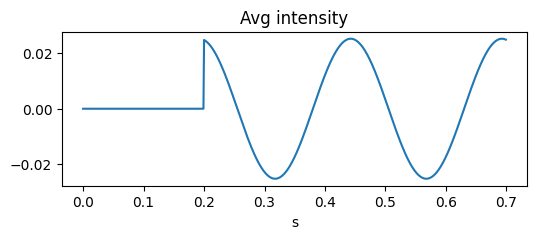

In [3]:
row, col = 120, 240
frame_rate = 1000.0
movie = drifting_grating(row, col, frame_rate, duration=0.5, gray_screen=0.2, cpd=0.04, temporal_f=4.0, theta=0.0, contrast=0.8)
print('Stimulus:', movie.shape, 'frame_rate:', movie.frame_rate)
plt.figure(figsize=(6,2)); plt.plot(movie.t_range, movie.as_array().mean(axis=(1,2))); plt.title('Avg intensity'); plt.xlabel('s'); plt.show()

## 2) Generate population

Population size: 72
Types: {np.str_('sOFF'): 24, np.str_('sON'): 48}


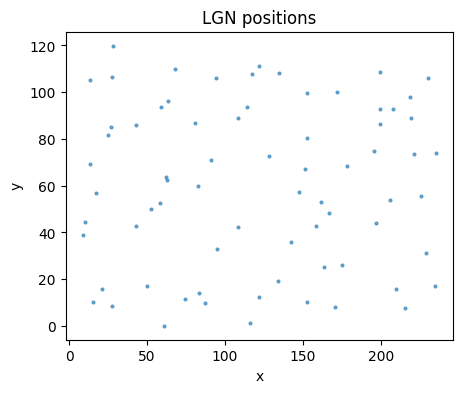

In [4]:
layout = { 'X_grids': 6, 'Y_grids': 4, 'X_len': 240.0, 'Y_len': 120.0 }
cell_types = [
  { 'name': 'sON',  'n_per_tile': 2, 'spatial': {'sigma_range':[2.0,3.0]}, 'temporal': {'weights':[0.6,-0.4], 'kpeaks':[15.0,45.0], 'delays':[0,0], 'jitter_percent':0.05}, 'amplitude_range':[1.5,2.0],  'transfer': {'bias_range':[0.8,1.2]} },
  { 'name': 'sOFF', 'n_per_tile': 1, 'spatial': {'sigma_range':[2.0,3.0]}, 'temporal': {'weights':[0.5,-0.3], 'kpeaks':[20.0,60.0], 'delays':[0,0], 'jitter_percent':0.05}, 'amplitude_range':[-2.0,-1.5], 'transfer': {'bias_range':[0.5,1.0]} }
]
lfs, trs, meta = generate_population(cell_types, layout, base_seed=123)
N = len(lfs); print('Population size:', N)
types = {t: int((meta['types']==t).sum()) for t in np.unique(meta['types'])}
print('Types:', types)
plt.figure(figsize=(5,4)); plt.scatter(meta['positions'][:,0], meta['positions'][:,1], s=4, alpha=0.6); plt.title('LGN positions'); plt.xlabel('x'); plt.ylabel('y'); plt.show()

## 3) Evaluate rates with BS/JAX (separable, multi)

c:\Users\76629\anaconda3\envs\brainlgn\Lib\site-packages\bmtk\simulator\filternet\lgnmodel\kernel.py:132: RuntimeWarning: invalid value encountered in divide
  self.kernel /= np.abs(self.kernel.sum())


BS multi rates shape: (72, 700) time(s): 1.0219389999983832
NaN count in rates_bs: 0


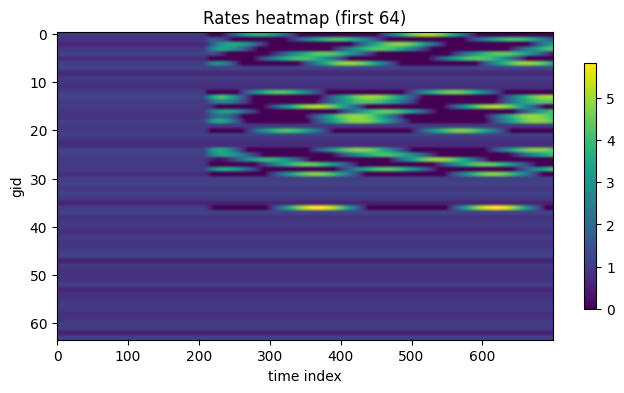

In [5]:
os.environ.setdefault('BRAINLGN_JAX_X64', '1')
os.environ.setdefault('BRAINLGN_FALLBACK_BMTK_ON_NAN', '1')
stim = movie.as_array()
t0=time.perf_counter(); rates_bs = eval_separable_multi(lfs, trs, stim, frame_rate=movie.frame_rate, downsample=1); t1=time.perf_counter()
print('BS multi rates shape:', rates_bs.shape, 'time(s):', t1-t0)
print('NaN count in rates_bs:', np.isnan(rates_bs).sum())
ns = min(64, rates_bs.shape[0])
plt.figure(figsize=(8,4)); plt.imshow(rates_bs[:ns], aspect='auto', cmap='viridis'); plt.title(f'Rates heatmap (first {ns})'); plt.xlabel('time index'); plt.ylabel('gid'); plt.colorbar(shrink=0.8); plt.show()

## 4) Parity on a subset vs BMTK

Parity (first K): MAE=1.968e-16, MaxAbs=3.553e-15


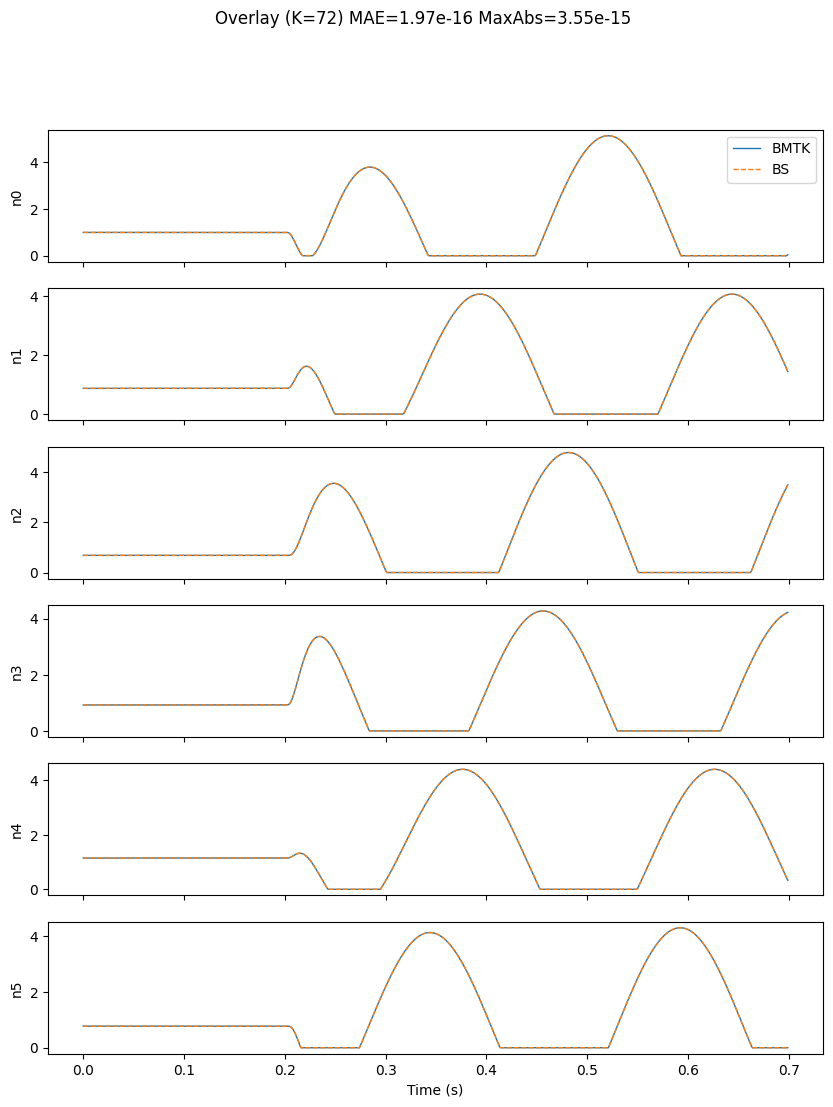

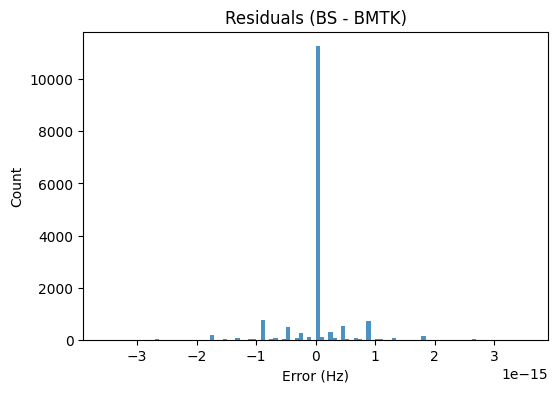

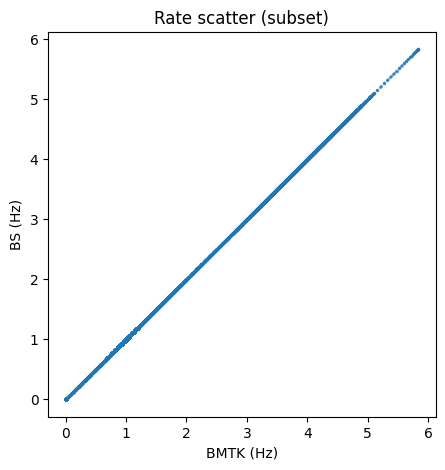

In [6]:
K = min(128, N)
mv = BMovie(stim, frame_rate=movie.frame_rate)
ref=[]
for i in range(K):
    ln = LNUnit(lfs[i], trs[i])
    _, y = ln.get_cursor(mv, separable=True).evaluate()
    ref.append(np.array(y))
rates_ref = np.stack(ref, axis=0)
mae = np.nanmean(np.abs(rates_ref - rates_bs[:K]))
mx  = np.nanmax(np.abs(rates_ref - rates_bs[:K]))
print('Parity (first K): MAE=%.3e, MaxAbs=%.3e' % (mae, mx))

# Overlay a few traces
n_show = min(6, K); T = rates_ref.shape[1]; t = np.arange(T)/movie.frame_rate
fig, axes = plt.subplots(n_show, 1, figsize=(10, 2*n_show), sharex=True)
if n_show == 1: axes=[axes]
for i in range(n_show):
    axes[i].plot(t, rates_ref[i], label='BMTK', lw=1)
    axes[i].plot(t, rates_bs[i], '--', label='BS', lw=1)
    axes[i].set_ylabel(f'n{i}')
    if i==0: axes[i].legend()
axes[-1].set_xlabel('Time (s)'); fig.suptitle(f'Overlay (K={K}) MAE={mae:.2e} MaxAbs={mx:.2e}'); plt.show()

# Residual histogram
resid = (rates_bs[:K] - rates_ref).ravel()
plt.figure(figsize=(6,4)); plt.hist(resid, bins=100, alpha=0.8); plt.title('Residuals (BS - BMTK)'); plt.xlabel('Error (Hz)'); plt.ylabel('Count'); plt.show()

# Scatter
plt.figure(figsize=(5,5)); plt.scatter(rates_ref.ravel(), rates_bs[:K].ravel(), s=2, alpha=0.3)
lim = max(rates_ref.max(), rates_bs[:K].max())
plt.plot([0, lim], [0, lim], 'k--', lw=1); plt.xlabel('BMTK (Hz)'); plt.ylabel('BS (Hz)'); plt.title('Rate scatter (subset)'); plt.show()

## 5) Optional: spikes and outputs

In [7]:
dt = 1.0 / movie.frame_rate
gids, times = generate_inhomogeneous_poisson(rates_bs, dt=dt, base_seed=999)
print('Total spikes:', len(times))
out_dir = os.path.abspath('./_outputs_population')
os.makedirs(out_dir, exist_ok=True)
write_rates_h5(os.path.join(out_dir, 'rates.h5'), rates_bs, movie.frame_rate)
write_spikes_csv(os.path.join(out_dir, 'spikes.csv'), gids, times)
write_spikes_h5(os.path.join(out_dir, 'spikes.h5'), gids, times)
print('Wrote outputs to:', out_dir)

Total spikes: 50
Wrote outputs to: c:\Users\76629\OneDrive\brain\repos\brainlgn\brainlgn-X\notebooks\_outputs_population
